In this notebook we evaluate the explainability of two models : KAN and Random Forest, on the California Housing dataset from Scikit-learn. To do this, we'll be using two popular methods, SHAP and PFI.

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git #Importing the KAN code from github

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-uxpkc3sh
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-uxpkc3sh
  Resolved https://github.com/KindXiaoming/pykan.git to commit d51e849bc7e95bc9733d4259e61192ba9bffa697
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78190 sha256=84797eb416c37aa2b2f997ccc8f75d469485a4023f215b07310814726f6174c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-49t2evbl/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


Import packages

In [2]:
from kan import KAN
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

Data Analysis and Cleaning

In [ ]:
housing_data = datasets.fetch_california_housing()

In [ ]:
# Create a DataFrame using the data and feature names
df = pd.DataFrame(data=housing_data.data, columns=housing_data.feature_names)
df['Target'] = housing_data.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
X = df.drop('Target', axis=1)
y = df['Target']

X.dropna(inplace=True)
y.dropna(inplace=True)
y = y[X.index]  # Align y with the remaining X

In [ ]:
# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [ ]:
# Drop NaNs in X_train, X_val, and X_test
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)

In [ ]:
# transforming the data
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [ ]:

'''''''''
# Simplified parameter grid
param_grid = {
    "max_depth": [None, 10, 12, 15],
    "min_samples_leaf": [1, 2, 4],
    "n_estimators": [100, 200, 300],
    "max_samples": [0.8, 0.9, 0.99]
}

# Initialize the base Random Forest model
rf = RandomForestRegressor(random_state=1)

# Set up GridSearchCV with fewer iterations
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)
# Fit the model with hyperparameter tuning
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)'''''''''

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'max_samples': 0.9, 'min_samples_leaf': 2, 'n_estimators': 300}


Random Forest

In [ ]:
# Random Forest model
rf_model = RandomForestRegressor(
    max_depth=None,
    max_samples=0.9,
    min_samples_leaf=1,
    n_estimators=300,
    random_state=1
)

rf_model.fit(X_train, y_train)

# Make predictions using the best model
train_preds_rf = rf_model.predict(X_train)
test_preds_rf = rf_model.predict(X_test)

# Evaluate metrics
print("Train R2 Score:", r2_score(y_train, train_preds_rf))
print("Train MAE:", mean_squared_error(y_train, train_preds_rf))

print("Test R2 Score:", r2_score(y_test, test_preds_rf))
print("Test MAE:", mean_squared_error(y_test, test_preds_rf))

Train R2 Score: 0.9675834978786
Train MAE: 0.04314076247916314
Test R2 Score: 0.7979650738379954
Test MAE: 0.26975499276727105


PFI for Random Forest

 PFI Feature Importance :
      Feature  Importance   Std Dev
0      MedInc    1.140485  0.056887
6    Latitude    0.445830  0.019323
7   Longitude    0.407999  0.018540
5    AveOccup    0.257327  0.028430
1    HouseAge    0.098603  0.010386
2    AveRooms    0.021833  0.003503
3   AveBedrms    0.015183  0.003424
4  Population    0.006551  0.002565


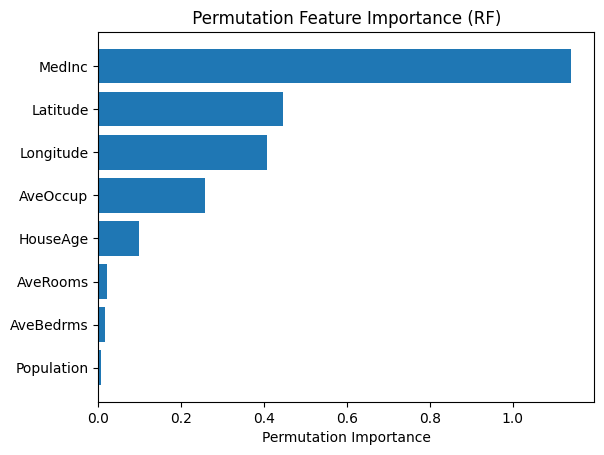

In [ ]:
# Sampling data
X_test_sample = X_test.sample(n=1000, random_state=42)
y_test_sample = y_test.sample(n=1000, random_state=42)

# Calculate PFI using permuation_importance from Scikit-learn
pfi_result = permutation_importance(rf_model, X_test_sample, y_test_sample, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

# Create a DataFrame to store the importance results
pfi_importances_rf = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': pfi_result.importances_mean,
    'Std Dev': pfi_result.importances_std
})

# Sort the features by importance
pfi_importances_sorted = pfi_importances_rf.sort_values(by='Importance', ascending=False)

print(" PFI Feature Importance :")
print(pfi_importances_sorted)

# Plot the feature importance
plt.barh(pfi_importances_sorted['Feature'], pfi_importances_sorted['Importance'])
plt.xlabel("Permutation Importance")
plt.title(" Permutation Feature Importance (RF) ")
plt.gca().invert_yaxis()

SHAP for Random Forest

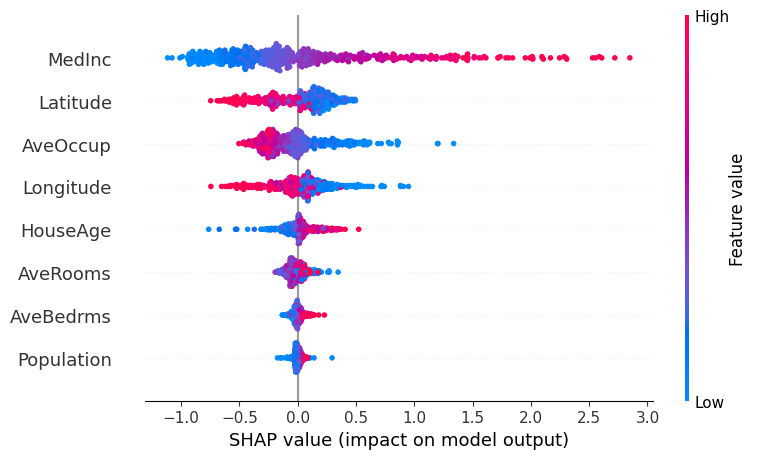

In [ ]:
# Initialize SHAP explainer for the Random Forest model
X_test_sample = X_test.sample(n=500, random_state=42)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer(X_test_sample)

shap.summary_plot(shap_values_rf, X_test_sample)

shap_importances = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values_rf.values).mean(axis=0)
})
shap_importances_sorted = shap_importances.sort_values(by='Importance', ascending=False)

Agreement metric

In [ ]:
# Function to measure greement for the top k features using Jaccard Index
def agreement_metric(top_k_shap, top_k_pfi):
    set_shap = set(top_k_shap)
    set_pfi = set(top_k_pfi)

    intersection = len(set_shap.intersection(set_pfi))
    union = len(set_shap.union(set_pfi))

    score = intersection / union if union != 0 else 0
    return score

In [ ]:
# Define k the number of top features to compare
k = 4

# Extract top k features
top_k_shap = shap_importances_sorted['Feature'][:k]
top_k_pfi = pfi_importances_sorted['Feature'][:k]

score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Jaccard Index for the top {k} features using Random Forest: {score:.4f}")

Jaccard Index for the top 4 features using Random Forest: 1.0000


KAN Model

In [ ]:
""" import numpy as np
import itertools

# Define the hyperparameters and their values
param_grid = {
    'width': [[8, 5, 1], [8, 7, 1], [8, 7, 5, 1]],  # Example values for width
    'grid': [8, 10, 50, 100] # Example values for grid

}

# Function to create, fit and evaluate the KAN model
def evaluate_kan_model(width, grid, train_input, train_label, val_input, val_label):
    model = KAN(width=width, grid=grid, k=3, seed=0)  # Create the KAN model
    results = model.fit(
        {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
        opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss()  # Use MSELoss for regression
    )
    # Here you should evaluate your model on the validation set
    val_predictions = model(val_input)  # Get predictions on the validation set
    val_loss = torch.nn.MSELoss()(val_predictions, val_label)  # Calculate validation loss
    return val_loss.item()  # Return the validation loss as a metric

# Initialize variables to track the best model and its score
best_score = float('inf')
best_params = None

# Create all combinations of hyperparameters
for width, grid in itertools.product(param_grid['width'], param_grid['grid']):
    print(f"Evaluating model with width={width}, grid={grid}")
    score = evaluate_kan_model(width, grid, train_input, train_label, val_input, val_label)

    if score < best_score:  # Check if the current score is better than the best score found
        best_score = score
        best_params = (width, grid)

print(f"Best Parameters: width={best_params[0]}, grid={best_params[1]}")
print(f"Best Validation Score (MSE): {best_score}")

Evaluating model with width=[8, 5, 1], grid=8
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.94e-01 | test_loss: 8.47e-01 | reg: 6.96e+01 | : 100%|█| 50/50 [06:19<00:00,  7.59s/


saving model version 0.1
Evaluating model with width=[[8, 0], [5, 0], [1, 0]], grid=10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.14e+00 | test_loss: 1.14e+00 | reg: 1.72e+01 | : 100%|█| 50/50 [03:32<00:00,  4.24s/


saving model version 0.1
Evaluating model with width=[[8, 0], [5, 0], [1, 0]], grid=50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.31e-01 | test_loss: 8.11e-01 | reg: 1.12e+01 | : 100%|█| 50/50 [18:20<00:00, 22.00s/


saving model version 0.1
Evaluating model with width=[[8, 0], [5, 0], [1, 0]], grid=100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.16e-01 | test_loss: 8.56e-01 | reg: 1.13e+01 | : 100%|█| 50/50 [37:00<00:00, 44.41s/


saving model version 0.1
Evaluating model with width=[8, 7, 1], grid=8
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.57e-01 | test_loss: 7.83e-01 | reg: 1.42e+03 | : 100%|█| 50/50 [05:53<00:00,  7.08s/


saving model version 0.1
Evaluating model with width=[[8, 0], [7, 0], [1, 0]], grid=10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.11e-01 | test_loss: 8.29e-01 | reg: 2.30e+03 | : 100%|█| 50/50 [10:04<00:00, 12.09s/


saving model version 0.1
Evaluating model with width=[[8, 0], [7, 0], [1, 0]], grid=50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.78e-01 | test_loss: 1.39e+00 | reg: 2.77e+03 | : 100%|█| 50/50 [17:09<00:00, 20.59s/


saving model version 0.1
Evaluating model with width=[[8, 0], [7, 0], [1, 0]], grid=100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.07e+00 | test_loss: 1.08e+00 | reg: 1.35e+01 | : 100%|█| 50/50 [31:04<00:00, 37.29s/


saving model version 0.1
Evaluating model with width=[8, 7, 5, 1], grid=8
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.64e-01 | test_loss: 8.44e-01 | reg: 9.62e+01 | : 100%|█| 50/50 [11:36<00:00, 13.92s/


saving model version 0.1
Evaluating model with width=[[8, 0], [7, 0], [5, 0], [1, 0]], grid=10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.95e-01 | test_loss: 7.11e-01 | reg: 8.62e+01 | : 100%|█| 50/50 [12:35<00:00, 15.11s/


saving model version 0.1
Evaluating model with width=[[8, 0], [7, 0], [5, 0], [1, 0]], grid=50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.64e-01 | test_loss: 8.19e-01 | reg: 7.76e+02 | : 100%|█| 50/50 [33:12<00:00, 39.85s/


saving model version 0.1
Evaluating model with width=[[8, 0], [7, 0], [5, 0], [1, 0]], grid=100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.06e-01 | test_loss: 7.32e-01 | reg: 5.18e+02 | : 100%|█| 50/50 [1:31:41<00:00, 110.0


saving model version 0.1
Best Parameters: width=[[8, 0], [7, 0], [5, 0], [1, 0]], grid=10
Best Validation Score (MSE): 0.5055865049362183


Test with Best KAN

In [ ]:
# Create the KAN model
model2 = KAN(width=[8, 7, 5, 1], grid=8, k=3, seed=0)  # one hidden layer with 5 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
results2 = model2.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.MSELoss() # Use MSELoss for regression
)

| train_loss: 6.69e-01 | test_loss: 6.78e-01 | reg: 2.85e+01 | : 100%|█| 50/50 [07:22<00:00,  8.86s/

saving model version 0.1


In [ ]:
# Predictions of train val and test datasets
test_preds = model2.forward(test_input).detach()
test_labels = test_label

train_preds = model2.forward(train_input).detach()
train_labels = train_label

val_preds = model2.forward(val_input).detach()
val_labels = val_label

# Evaluation
print("Train R2 Score:", r2_score(train_labels.numpy(), train_preds.numpy()))
print("Train MAE:", mean_squared_error(train_labels.numpy(), train_preds.numpy()))

print("Val R2 Score:", r2_score(val_labels.numpy(), val_preds.numpy()))
print("Val MAE:", mean_squared_error(val_labels.numpy(), val_preds.numpy()))

print("Test R2 Score:", r2_score(test_labels.numpy(), test_preds.numpy()))
print("Test MAE:", mean_squared_error(test_labels.numpy(), test_preds.numpy()))

Train R2 Score: 0.6635957956314087
Train MAE: 0.4476959
Val R2 Score: 0.654312789440155
Val MAE: 0.45960143
Test R2 Score: 0.6545801162719727
Test MAE: 0.46120113


PFI for KAN

     Features  Importances
0      MedInc     1.612551
5    AveOccup     0.541834
2    AveRooms     0.089170
1    HouseAge     0.056753
7   Longitude     0.054679
3   AveBedrms     0.037223
4  Population     0.019662
6    Latitude     0.007784


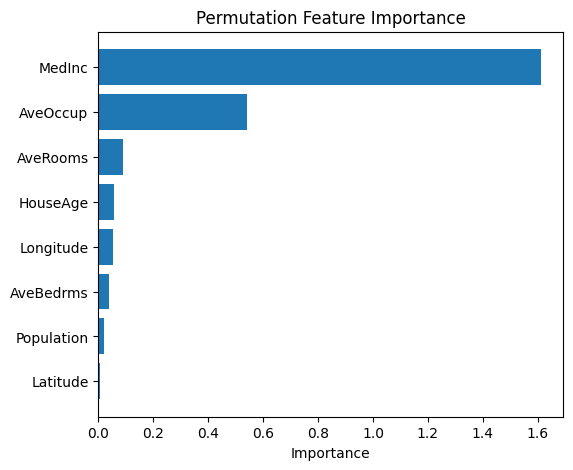

In [ ]:
# Function to evaluate model performance using MSE
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X, dtype=torch.float32)).numpy()
    return mean_squared_error(y, predictions)

# Calculate permutation feature importance (PFI)
def permutation_importance(model, X, y, metric=evaluate_model, n_repeats=10):
    baseline_score = metric(model, X, y)
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(model, X_permuted, y)
            scores.append(score)
        importances[i] = np.mean(scores) - baseline_score

    return importances

# Convert validation data to numpy arrays
X_val_tensor = X_val.to_numpy()
y_val_tensor = y_val.to_numpy()

# Calculate feature importances
importances_kan = permutation_importance(model2, X_val_tensor, y_val_tensor)

# Create DataFrame with feature importances
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Features': feature_names,
    'Importances': importances_kan
}).sort_values(by='Importances', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(6, 5))
plt.barh(importance_df['Features'], importance_df['Importances'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


SHAP for KAN

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  output_range_spline = torch.std(postacts_numerical, dim

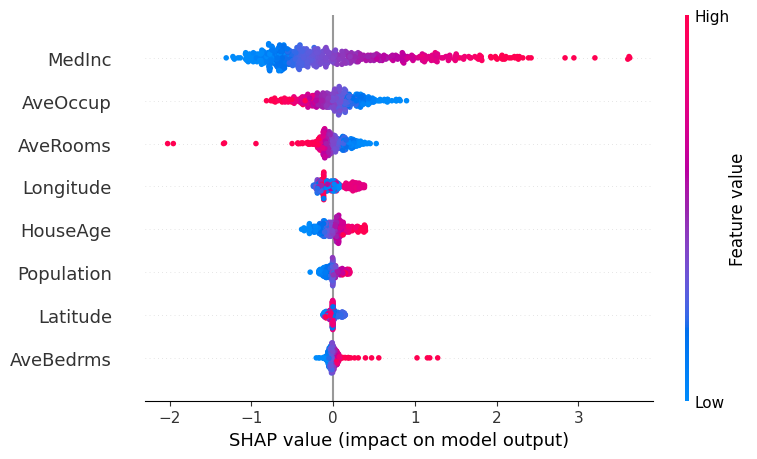

In [ ]:
# Define a prediction function
def predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        preds = model2(data_tensor).numpy()
    return preds

# Sampling data
X_train_subset = X_train.sample(500, random_state=42).to_numpy()
X_test_subset = X_test.sample(500, random_state=42).to_numpy()

explainer = shap.KernelExplainer(predict, X_train_subset)

shap_values = explainer.shap_values(X_test_subset)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

shap_values = np.squeeze(shap_values)

shap_df_kan= pd.DataFrame(shap_values, columns=X_test.columns)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_subset, feature_names=X_test.columns)

Agreement metric

In [ ]:
#Creating lists of top k features of shap and pfi for KAN
k = 4
top_k_pfi_features_kan = ['MedInc', 'AveOccup', 'AveRooms', 'HouseAge']
top_k_shap_features_kan = ['MedInc', 'AveOccup', 'AveRooms', 'Longitude']


score_kan = agreement_metric(top_k_shap_features_kan, top_k_pfi_features_kan)
print(f"Jaccard Index for the top {k} features using KAN: {score_kan:.4f}")

Jaccard Index for the top 4 features using KAN: 0.6000
